# Generalised linear models

In this notebook we will train different linear models on synthetic datasets using __[Batchflow](https://github.com/analysiscenter/batchflow)__ module.

## 1. Linear regression

### Task description

Given a dataset of features $X$: $X \subset R^n $ and targets $y$: $y \subset R $, assume that targets are generated by the law $y = w_0 +w_1x_1 + w_2x_2 + ... + w_nx_n + N(0, 1)$, where $N$ is Gaussian distribution.   
In oder to find optimal parameters $w_0, w_2, w_1 ..$ of the model we need to minimise Mean Squeared Error loss function.   
$$ min_w  \frac{1}{n} \sum(y_i - w^Tx)^2 $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from batchflow import Dataset, V, B, Batch
from batchflow.models.torch import TorchModel
from torch.nn import PoissonNLLLoss
%matplotlib inline

In [2]:
def data_generator(size, dim):
    """ Generation of data for linear regression.
    
    Parameters
    ----------
    size: int 
        The size of the dataset.
    
    dim: int
        Features dimensionality.
    
    Returns:
    ----------
    x: np.array
        Feature representation of the objects.
    
    y: np.array
        Targets of the objects.
    
    real: list
        True coefficients of linear combination. 
    """
    x = np.random.uniform(1, 3, size=(size, dim)) 
    
    w = np.random.randint(1, 5, size=dim)
    b = np.random.randint(1, 5)
    real = [w, b]
    
    y = x @ w + b + np.random.normal(scale=0.5, size=size)
    return x.astype('float32'), y.astype('float32'), real

### Dataset

We generated synthetic dataset where the target is a truly linear combination of features with some weights, plus some normally distributed noise being added.   
Weights are sampled from the uniform distribution.   
Take a look at 1-d features dataset generated.

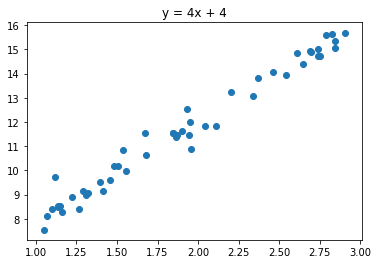

In [14]:
x, y, real = data_generator(50, 1)
plt.scatter(x, y)
plt.title('y = {}x + {}'.format(real[0][0], real[1]))
plt.show()

Now lets generate a bit more complicated dataset for futher investigation.

In [15]:
size, dim = 500, 2
x, y, real = data_generator(size, dim) 

### Model

As mentioned above, we use linear regression model which can be represented as Neural Network with 1  neuron.

In [16]:
from batchflow.models.torch.layers import Dense
class MyModel(TorchModel):
    
    def body(cls, **kwargs):
        kwargs.pop('data_format')
        x = Dense(units=1, **kwargs)
        return x

Defining MyBatch class. It inherited from __[BatchClass](https://analysiscenter.github.io/batchflow/intro/batch.html)__. We only add names for the components

In [17]:
class MyBatch(Batch):
    components = 'features', 'targets'

Bellow we set some model and training process configuration.
1. Inputs shape of the objects in our case -  2 dimension
2. Loss function - MSE
3. Optimizer - we will be using  __[Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)__
    1. Parameter of training process - learning rate, rate at which we will be updating weights of out model


In [18]:
model_config = {
    'inputs': dict(features={'shape': dim},
                  targets={'shape': 1}),
    'initial_block/inputs': 'features',
    'loss': 'mse',
    'optimizer': {'name': 'SGD',
                  'lr': 0.001}
}

### Training

Our pipeline do not apply any data preprocessing actions.   
We use model declared above and train it 100 epochs usuing batches with the size 64.

In [19]:
dataset = Dataset(index=size, batch_class=MyBatch) 
dataset.split()

BATCH_SIZE = 64

lin_train = (dataset.train.p
            .load(src=(x,y))
            .init_variable('loss_history', init_on_each_run=list)
            .init_model('dynamic', MyModel, 'lin_model', model_config)
            .train_model('lin_model', B('features'), B('targets'), 
                         fetches='loss', save_to=V('loss_history'), mode='a')
            .run(BATCH_SIZE, shuffle=True, n_epochs=100))

Lets track loss history during the training to ensure that we converge to some optimum

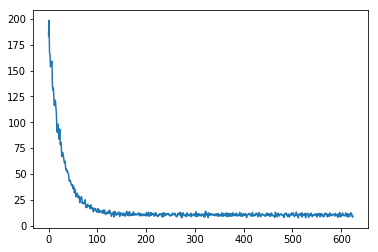

In [20]:
plt.plot(np.array(lin_train.get_variable('loss_history')))

### Model validation

Lets measure the quality of our model. We look at the Mean Absolute Percentage Error metric on the test dataset.

In [21]:
test_size = dataset.calc_split()[1]
lin_test = (dataset.test.p
            .load(src=(x,y))
            .init_variable('predictions')
            .import_model('lin_model', lin_train)
            .predict_model('lin_model', B('features'), 
                           fetches='predictions', save_to=V('predictions'), mode='a')
            .run(batch_size=test_size, n_epochs=1))

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) * 100 / y_true ))

y_pred = lin_test.get_variable('predictions')
y_true = y[-test_size:]
print('Mean Absolute Persentage Error on Test : {0:.2f}%'.format(mape(y_true, y_pred)))

Mean Absolute Persentage Error on Test : 21.40%


Lets take a look at the estimated parameters and compare them to the real ones.

In [42]:
l = list(lin_test.models.models['lin_model'].model.modules())
b = list(l[2].parameters())[1][0].item()
w1, w2 = list(l[2].parameters())[0][0].detach().numpy()
print('Real parameters w1: {}, w2: {}, b: {}'.format(real[0][0], real[0][1], real[1]))
print('Trained parameters w1: {:.2f}, w2: {:.2f}, b: {:.2f}'.format(w1, w2, b))

Real parameters w1: 1, w2: 4, b: 2
Trained parameters w1: 2.48, w2: 2.62, b: 1.40


## Logistic regression

### Task description

Given a dataset of features $X$: $X \subset R^n $ and targets $y$: $y \in [0, 1]$ we need to solve classificatoin task i.e. classify each object to one or another class given its features representation.    
In order to do this, we use logictic regression model which estimates the probability that the object came from the class one.   
$$p(y | x) \sim Bernoulli(\sigma) $$
$$ \sigma = \frac{1}{1+e^{w^Tx}} $$

In [43]:
def generate_data(size):
    """ Generation of the data for logistic regression. 

    Parameters
    ----------
    size: int
        The size of the dataset.
    
    Returns:
    ----------
    x: np.array
        Feature 2 dimensional feature representation of the objects.
    
    y: np.array
        Class labels of the objects.
    """
    half_size = int(size/2)
    x_0 = np.random.multivariate_normal((1, 1), ([1, 0], [0, 1]), size=half_size)
    x_1 = np.random.multivariate_normal((5, 5), ([1, 0], [0, 1]), size=half_size)
    targets = [0] * half_size + [1] * half_size
    x = np.concatenate((x_0, x_1))
    return x.astype('float32'), np.array(targets).astype('float32')

### Dataset

We generate synthetic dataset with 2 classes.   
The points of the first class  come from the Normal distribution with the mean (1, 1) and zero covariance matrix.   
The points of the second class  come from the Normal distribution with the mean (5, 5) and zero covariance matrix

In [44]:
size = 300
x, y = generate_data(size)

Lets take a look at the generated dataset.

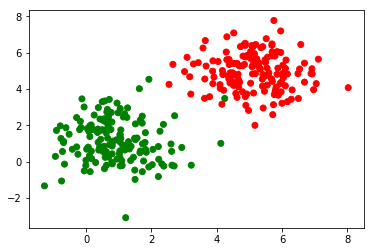

In [45]:
color = ['r' if i else 'g' for i in y]
plt.scatter(x.T[0], x.T[1], color=color)

### Model

Logistic regression model can be represented as Neural Network with 1 neuron and Sigmoid activation function.   
We need to minimize LogLoss or so-called called Cross Entropy loss function in oder to find optimal parameters.
$$\frac{1}{n} \sum(- y_i\log{\sigma_i} - (1-y_i)\log{(1 - \sigma_i)}) $$

In [46]:
from torch.nn import BCELoss

model_config = {
    'inputs': dict(features={'shape': 2},
                  targets={'shape': 1}),
    'initial_block/inputs': 'features',
    'loss': BCELoss,
    'optimizer': {'name': 'SGD',
                 'lr': 0.1},
    'body/layout': 'fa',
    'body/activation': 'Sigmoid',
    'body/units': 1
}

### Training

We train our model 300 epochs with the batch size 64.   
As you can see above, we set learning rate for this task much bigger since the optimizer converging too slowly.   
Alternatevly we could set more training epochs.

In [47]:
dataset = Dataset(index=size, batch_class=MyBatch) 
dataset.split()

BATCH_SIZE = 64

logit_train = (dataset.train.p
            .load(src=(x,y))
            .init_variable('loss_history', init_on_each_run=list)
            .init_model('dynamic', TorchModel, 'logit_model', model_config)
            .train_model('logit_model', B('features'), B('targets'), 
                         fetches='loss', save_to=V('loss_history'), mode='a')
            .run(BATCH_SIZE, shuffle=True, n_epochs=300))

Lets take a look at the loss during traiing to make sure that the procedure converges. 

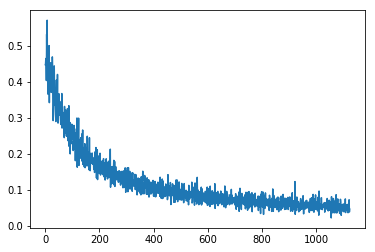

In [48]:
plt.plot(np.array(logit_train.get_variable('loss_history')))

### Model validation

In [49]:
test_size = dataset.calc_split()[1]
logit_test = (dataset.train.p
            .load(src=(x,y))
            .import_model('logit_model', logit_train)
            .init_variable('predictions')
            .init_variable('metrics', init_on_each_run=None)
            .predict_model('logit_model', B('features'), B('targets'), 
                           fetches='predictions', save_to=V('predictions'))
            .gather_metrics('class', targets=B('targets'), 
                            predictions=V('predictions'), save_to=V('metrics'), mode='a')
            .run(test_size, shuffle=False, n_epochs=1)
)

To verify the quality of the model lets take a look on the accuracy metric, which displays the portion of objects properly classified, on the test dataset

In [60]:
metrics = logit_test.get_variable('metrics')
acc = metrics.evaluate('accuracy')
print('Accuracy on test data - {:.1f}%'.format(100 * acc))

Accuracy on test data - 98.8%


## Poisson regression

### Task description

Lets assume now, that we have the regression task and our target takes only positive integers values.   
For such cases one of the ideas is to assume that data comes from the __[Poisson](https://en.wikipedia.org/wiki/Poisson_distribution)__ distribution. This disctribution has one parameter - $\lambda$, which defines the mean and the variance. $$ p(y| \lambda) = \frac{\lambda^y}{y!} e^{-\lambda} $$ 

In [71]:
def generate_data(size, dim):
    """ Generation of data for Poisson regression
    
    Parameters
    ----------
    size: int
        Size of the dataset.
    
    dim: int
        Features dimensionality.
    
    Returns:
    ----------
    x: np.array
        Feature representation of the objets.
    
    y: np.array
        Targets of the objects.
    """
    x = np.random.uniform(0.1, 1, size=(size, dim))
    
    b = np.random.randint(-1, 3)
    w = np.random.uniform(1, 3, size=dim)
    
    y = np.random.poisson(np.exp(np.dot(x, w) + b))
    return x.astype('float32'), y.astype('float32').reshape(-1,1)

### Dataset

Lets generate some 1d points from the Poisson distribution. Though its hard to  notice,  y takes only integer values.

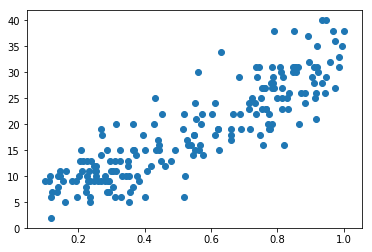

In [142]:
x, y = generate_data(200, 1)
plt.scatter(x,y)

### Model

Assume that the parameter of Poisson distribution $\lambda$ for a given point of the dataset can be estimated as $ \lambda = e^{w^{T}x} $.   
We need to minimize the following loss function in oder to find optimal parameters $$ \frac{1}{n} \sum(y_iw^{T}x - e^{w^{T}x}) $$
Just like in the examples above, we can represent our model as a Neural Net with 1 neuron.   
Note that we set low learning rate.

In [143]:
from torch.nn import PoissonNLLLoss

model_config = {
    'inputs': dict(features={'shape': dim},
                  targets={'shape': 1}),
    'initial_block/inputs': 'features',
    'loss': PoissonNLLLoss,
    'optimizer': {'name': 'SGD',
                 'lr': 0.00001},
    'body/layout': 'f',
    'body/units': 1
}

### Training

Lets train our model 20_000 epochs to see longterm behaivour of the loss function on such simple dataset.

In [144]:
dataset = Dataset(size, batch_class=MyBatch)
dataset.split()

BATCH_SIZE = 32

pois_train = (dataset.train.p
            .load(src=(x,y))
            .init_variable('loss_history', init_on_each_run=list)
            .init_model('dynamic', TorchModel, 'pois_model', model_config)
            .train_model('pois_model', B('features'), B('targets'), 
                         fetches='loss', save_to=V('loss_history'), mode='a')
            .run(BATCH_SIZE, shuffle=True, n_epochs=20000))

Loss fluctuates dramatically around some mean value, although we set learning rate small. Poisson regression has large variance.   
One of the explanations is that there is exponential part in the loss function as well as in the gradient which forces coefficients and therefore loss change significantly from step to step.

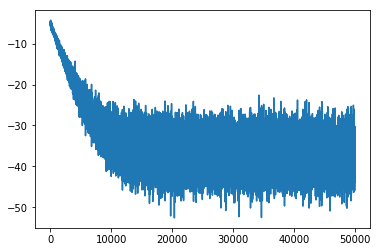

In [145]:
plt.plot(np.array(pois_train.get_variable('loss_history')))

### Model validation

In [148]:
test_size = dataset.calc_split()[1]
pois_test = (dataset.test.p
            .load(src=(x,y))
            .init_variable('predictions')
            .import_model('pois_model', pois_train)
            .predict_model('pois_model', B('features'), 
                           fetches='predictions', save_to=V('predictions'))
            .run(batch_size=test_size, shuffle=False, n_epochs=1))           

In [149]:
y_pred = pois_test.get_variable('predictions')
y_pred = np.exp(y_pred)
y_true = y[-test_size:]

In [150]:
print('Mean absolute Percentage Error on test data : {0:.2f}'.format(mape(y_true, y_pred)))

Mean absolute Percentage Error on test data : 104.54


## Summary

In this notebook we showed how to train linear models using Batchflow module. We mentioned different loss functions for different tasks, as well as some metricks to assess model quality. Though the models are quite simple, in case of Poisson regression we saw unstable learning proccess.   
The next step is to use more coplicated models to solve classification task on the MNIST dataset.